In [1]:
from gpxcsv import gpxtolist
import pandas as pd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from math import sin, cos, sqrt, atan2, radians
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from folium import Map
from folium.plugins import HeatMap

#%matplotlib inline
ox.config(log_console=True)
ox.__version__





'1.0.1'

La durada total del trajecte és de 1773.0 segons

La distància total recorreguda és de 1497.7650936872594 metres

La velocitat mitjana és de 1.8441861656184457 metres / segon ==> 6.639070196226404 kilometres / hora

-------------------------------------------

La durada total del trajecte és de 774.0 segons

La distància total recorreguda és de 1054.3392429495989 metres

La velocitat mitjana és de 1.6169103638112925 metres / segon ==> 5.820877309720653 kilometres / hora

-------------------------------------------



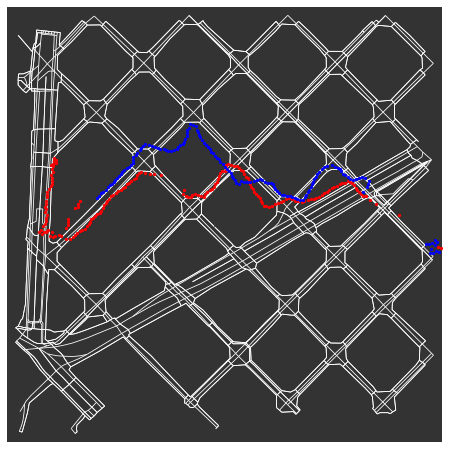

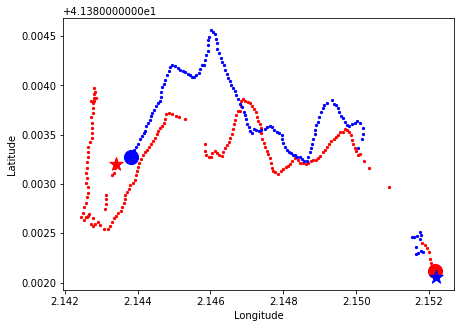

In [2]:
def getDistanceFromLatLonInM(lat1,lon1,lat2,lon2):
    R = 6371 # Radius of the earth in km
    dLat = radians(lat2-lat1)
    dLon = radians(lon2-lon1)
    rLat1 = radians(lat1)
    rLat2 = radians(lat2)
    a = sin(dLat/2) * sin(dLat/2) + cos(rLat1) * cos(rLat2) * sin(dLon/2) * sin(dLon/2) 
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c # Distance in km
    e= d*1000 #distance in m
    return e


all_files = glob.glob(os.path.join("*.gpx")) # Make list of paths (gpx files for all groups)

G = ox.graph_from_point((41.38279266639305, 2.14680426698555), dist=410, network_type='all')   # Create the graph from
fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor="#333333",edge_color="w", edge_linewidth=0.8, node_size=0)

fig, ax2 = plt.subplots(figsize=(7,5)) # The figure                              
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

list_colors=['red','blue','green','yellow','purple']
j=0

latitud_tots=[]
longitud_tots=[]

for file in all_files:   # Loop over all gpx files in the folder/directory  
    df = pd.DataFrame(gpxtolist(file))

    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
    temps=df['time'].tolist()
    lat=df['lat'].tolist()  # Latitude and Longitude to lists
    lon=df['lon'].tolist()
    latitud_tots.extend(lat)
    longitud_tots.extend(lon)
    
    ax.scatter(lon, lat,c=list_colors[j],s=5) # Scatter the GPS locs. with heatmap
    
    ax2.scatter(lon, lat,c=list_colors[j],s=5) # Scatter the GPS locs. with heatmap
    ax2.scatter(lon[0],lat[0], marker='*', c=list_colors[j], s=200)
    ax2.scatter(lon[-1],lat[-1], marker='o', c=list_colors[j], s=200)
    
    j=j+1

    diff_time=[]
    for i in range(1,len(df['time'])):
        diff=temps[i]-temps[i-1]
        diff_time.append(diff)
    diff_time.insert(len(diff_time), np.nan)
    df['At']=diff_time
    df['At']=df['At'].dt.seconds
    
    t=df['At'][:-1].tolist()
    print('La durada total del trajecte és de', sum(t), 'segons')
    print('')
    
    distance=[]
    for p in range(1,len(lat)):
        dist=getDistanceFromLatLonInM(lat[p-1],lon[p-1],lat[p],lon[p])
        distance.append(dist)    
    print('La distància total recorreguda és de', sum(distance), 'metres')
    print('')
    
    velocity=[]
    for jj in range(len(distance)):
        velocity.append(distance[jj]/t[jj])
    print('La velocitat mitjana és de', sum(velocity)/len(velocity), 'metres / segon', '==>',3.6*sum(velocity)/len(velocity),'kilometres / hora' )
    print('')
    print('-------------------------------------------')
    print('')
    

    
plt.show()


for_map = Map(location=[41.38279266639305, 2.14680426698555], zoom_start=15, )

hm_wide = HeatMap(
    list(zip(latitud_tots, longitud_tots)),
    min_opacity=0.2,
    radius=17, 
    blur=15, 
    max_zoom=1,
)

for_map.add_child(hm_wide)

In [47]:
df2 = pd.DataFrame(gpxtolist('comprar-i-pelu.gpx'))


In [48]:
df2

,lat,lon,name,cmt,desc,ele,time
0,41.383205,2.143420,Comprar i pelu,None,None,54.581,2022-02-02T18:49:37Z
1,41.383163,2.143377,Comprar i pelu,None,None,54.561,2022-02-02T18:49:43Z
2,41.383108,2.143362,Comprar i pelu,None,None,54.517,2022-02-02T18:49:50Z
3,41.383093,2.143297,Comprar i pelu,None,None,54.508,2022-02-02T18:49:54Z
4,41.382890,2.143144,Comprar i pelu,None,None,54.567,2022-02-02T18:50:08Z
...,...,...,...,...,...,...,...
181,41.382315,2.151991,Comprar i pelu,None,None,58.361,2022-02-02T19:18:41Z
182,41.382242,2.152026,Comprar i pelu,None,None,57.417,2022-02-02T19:18:59Z
183,41.382200,2.152064,Comprar i pelu,None,None,56.608,2022-02-02T19:19:02Z
184,41.382165,2.152112,Comprar i pelu,None,None,55.797,2022-02-02T19:19:06Z


In [61]:
import utm

lat_utm=[]
lon_utm=[]
count=0
for i in range(len(df2['lat'])):
    u = utm.from_latlon(df2['lat'][i], df2['lon'][i])
    if u[2]==31:
        count=count+1
    lat_utm.append(u[0])
    lon_utm.append(u[1])

In [50]:
df2['lat_utm']=lat_utm
df2['lon_utm']=lon_utm

In [51]:
df2['time'] = pd.to_datetime(df2['time'], format='%Y-%m-%d %H:%M:%S')
temps=df2['time'].tolist()
df2

,lat,lon,name,cmt,desc,ele,time,lat_utm,lon_utm
0,41.383205,2.143420,Comprar i pelu,None,None,54.581,2022-02-02 18:49:37+00:00,428378.818731,4.581652e+06
1,41.383163,2.143377,Comprar i pelu,None,None,54.561,2022-02-02 18:49:43+00:00,428375.177250,4.581647e+06
2,41.383108,2.143362,Comprar i pelu,None,None,54.517,2022-02-02 18:49:50+00:00,428373.862686,4.581641e+06
3,41.383093,2.143297,Comprar i pelu,None,None,54.508,2022-02-02 18:49:54+00:00,428368.411322,4.581639e+06
4,41.382890,2.143144,Comprar i pelu,None,None,54.567,2022-02-02 18:50:08+00:00,428355.395569,4.581617e+06
...,...,...,...,...,...,...,...,...,...
181,41.382315,2.151991,Comprar i pelu,None,None,58.361,2022-02-02 19:18:41+00:00,429094.505226,4.581546e+06
182,41.382242,2.152026,Comprar i pelu,None,None,57.417,2022-02-02 19:18:59+00:00,429097.352448,4.581538e+06
183,41.382200,2.152064,Comprar i pelu,None,None,56.608,2022-02-02 19:19:02+00:00,429100.484195,4.581533e+06
184,41.382165,2.152112,Comprar i pelu,None,None,55.797,2022-02-02 19:19:06+00:00,429104.459700,4.581529e+06


In [52]:
lat=df2['lat'].tolist()
lon=df2['lon'].tolist()
df2['time'] = pd.to_datetime(df2['time'], format='%Y-%m-%d %H:%M:%S')
temps=df2['time'].tolist()
distance=[]
distance2=[]
diff_time=[]

for p in range(1,len(df2['lat'])):
    dist=getDistanceFromLatLonInM(lat[p-1],lon[p-1],lat[p],lon[p])
    distance.append(dist) 
    dist2 = ( (lat_utm[p]-lat_utm[p-1])**2 + (lon_utm[p]-lon_utm[p-1])**2 ) ** 0.5
    distance2.append(dist2)
    diff=temps[p]-temps[p-1]
    diff_time.append(diff)

diff_time.insert(len(diff_time), np.nan)
df2['At']=diff_time
df2['At']=df2['At'].dt.seconds
    
distance.insert(len(distance), np.nan)
distance2.insert(len(distance2), np.nan)

velocity=[]
velocity2=[]
t=df2['At'].tolist()
for jj in range(len(t)):
    velocity.append(distance[jj]/t[jj])
    velocity2.append(distance2[jj]/t[jj])


df2['d']=distance
df2['d_utm']=distance2
df2['v']=velocity
df2['v_utm']=velocity2

In [53]:
df2

,lat,lon,name,cmt,desc,ele,time,lat_utm,lon_utm,At,d,d_utm,v,v_utm
0,41.383205,2.143420,Comprar i pelu,None,None,54.581,2022-02-02 18:49:37+00:00,428378.818731,4.581652e+06,6.0,5.889038,5.888269,0.981506,0.981378
1,41.383163,2.143377,Comprar i pelu,None,None,54.561,2022-02-02 18:49:43+00:00,428375.177250,4.581647e+06,7.0,6.242450,6.233801,0.891779,0.890543
2,41.383108,2.143362,Comprar i pelu,None,None,54.517,2022-02-02 18:49:50+00:00,428373.862686,4.581641e+06,4.0,5.673669,5.684582,1.418417,1.421145
3,41.383093,2.143297,Comprar i pelu,None,None,54.508,2022-02-02 18:49:54+00:00,428368.411322,4.581639e+06,14.0,25.931877,25.915831,1.852277,1.851131
4,41.382890,2.143144,Comprar i pelu,None,None,54.567,2022-02-02 18:50:08+00:00,428355.395569,4.581617e+06,1.0,5.010028,5.002370,5.010028,5.002370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,41.382315,2.151991,Comprar i pelu,None,None,58.361,2022-02-02 19:18:41+00:00,429094.505226,4.581546e+06,18.0,8.626492,8.616964,0.479250,0.478720
182,41.382242,2.152026,Comprar i pelu,None,None,57.417,2022-02-02 19:18:59+00:00,429097.352448,4.581538e+06,3.0,5.644646,5.642711,1.881549,1.880904
183,41.382200,2.152064,Comprar i pelu,None,None,56.608,2022-02-02 19:19:02+00:00,429100.484195,4.581533e+06,4.0,5.584260,5.586554,1.396065,1.396638
184,41.382165,2.152112,Comprar i pelu,None,None,55.797,2022-02-02 19:19:06+00:00,429104.459700,4.581529e+06,4.0,5.830858,5.829127,1.457715,1.457282


In [54]:
df2['v_utm'].mean()

1.845417783632351

In [55]:
df2['v'].mean()

1.8441861656184473

186


31
